In [113]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from scipy.special import lambertw

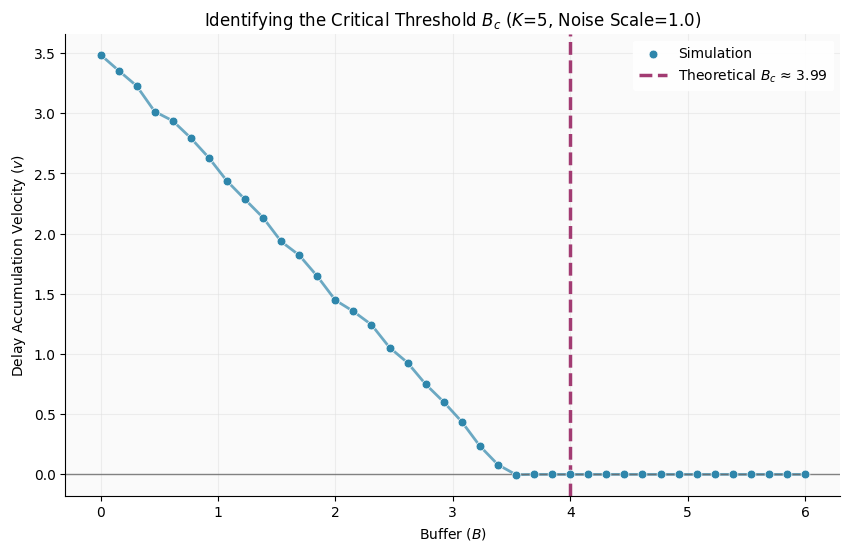

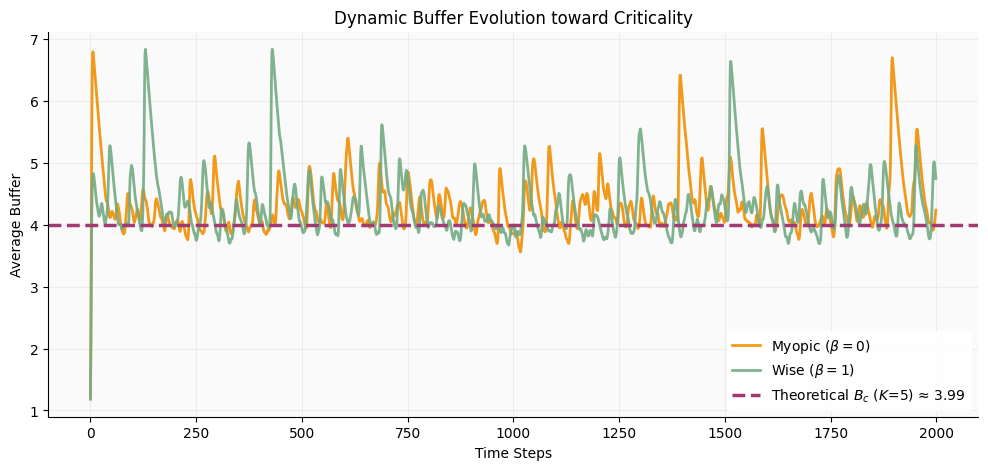

In [114]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from scipy.special import lambertw

# --- CONFIGURATION & ANALYTICAL THRESHOLD ---
N_NODES = 1000
K = 5
NOISE_SCALE = 1.0
B_INIT = 1.0
T_STEPS = 2000

# Analytical calculation of Bc: Bc * exp(1 - Bc) = 1/K
bc_theo = -lambertw(-1/(np.exp(1)*K), k=-1).real

def simulate_fixed_buffer(B, k, n, T, T_start, noise_scale=1.0):
    """
    Simulates the network with a STATIC buffer to measure delay accumulation velocity (v).
    """
    delays_last = np.zeros(n)
    v_history = []
    
    for t in range(T):
        eps = scipy.stats.expon.rvs(scale=noise_scale, size=n)
        delays_selected = np.zeros(n * k)
        for i in range(k):
            np.random.shuffle(delays_last)
            delays_selected[i*n : (i+1)*n] = delays_last
        delays_matrix = np.reshape(delays_selected, (n, k))
        
        total_load = np.max(delays_matrix, axis=1) + eps
        delays_curr = np.maximum(0, total_load - B)
        
        if t >= T_start:
            v_history.append(np.mean(delays_curr - delays_last))
        delays_last = delays_curr
    return np.mean(v_history)

def synthetic_temporal_network_soc(B_start, k, n, T, T_start, epsilon=0.09, alpha=0.7, beta=1.0, pipeline_len=5, noise_scale=1.0):
    """
    Simulates a Synthetic Temporal Network with Self-Organized Criticality (SOC).
    The buffer evolves locally toward the critical threshold Bc.
    """
    delays_last_iteration = np.zeros(n)
    buffers = np.full(n, B_start)
    pipeline_memory = np.zeros((n, pipeline_len))
    
    mean_delays = np.zeros(T - T_start)
    mean_buffers = np.zeros(T - T_start)
    
    for t in range(T):
        eps_noise = scipy.stats.expon.rvs(scale=noise_scale, size=n)
        delays_selected = np.zeros(n * k)
        for i in range(k):
            np.random.shuffle(delays_last_iteration)
            delays_selected[i*n : (i+1)*n] = delays_last_iteration
        delays_matrix = np.reshape(delays_selected, (n, k))
        
        total_incoming_load = np.max(delays_matrix, axis=1) + eps_noise
        delays_current = np.maximum(0, total_incoming_load - buffers)
        
        pipeline_sum = np.sum(pipeline_memory, axis=1)
        perceived_gap = delays_current - (beta * pipeline_sum)
        is_delayed = delays_current > 0.001
        
        delta_buffer = np.zeros(n)
        # Decision Logic: Sterman Correction vs Greed Efficiency
        delta_buffer[is_delayed] = alpha * np.maximum(0, perceived_gap[is_delayed])
        delta_buffer[~is_delayed] = -epsilon
        
        buffers = np.maximum(0, buffers + delta_buffer)
        actual_corrections = np.maximum(0, delta_buffer)
        pipeline_memory[:, :-1] = pipeline_memory[:, 1:]
        pipeline_memory[:, -1] = actual_corrections
        
        if t >= T_start:
            mean_delays[t - T_start] = np.mean(delays_current)
            mean_buffers[t - T_start] = np.mean(buffers)
        delays_last_iteration = delays_current
        
    return mean_delays, mean_buffers

# --- PLOT 1: IDENTIFYING THE CRITICAL THRESHOLD ---
buffers_test = np.linspace(0, 6, 40)
velocities = [simulate_fixed_buffer(b, K, N_NODES, 500, 100, NOISE_SCALE) for b in buffers_test]

# Color scheme
SIMULATION_COLOR = '#2E86AB'  # Deep blue
THEORETICAL_LINE_COLOR = '#A23B72'  # Purple/magenta for theoretical line (consistent)
MYOPIC_COLOR = '#F18F01'  # Orange
WISE_COLOR = '#73AB84'  # Green
GRID_COLOR = '#E0E0E0'
ZERO_LINE_COLOR = '#666666'

plt.figure(figsize=(10, 6))
plt.scatter(buffers_test, velocities, color=SIMULATION_COLOR, s=40, label='Simulation', edgecolors='white', linewidth=0.5, zorder=5)
plt.plot(buffers_test, velocities, color=SIMULATION_COLOR, alpha=0.7, linewidth=2)
plt.axhline(0, color=ZERO_LINE_COLOR, linestyle='-', alpha=0.8, linewidth=1)
plt.axvline(bc_theo, color=THEORETICAL_LINE_COLOR, linestyle='--', linewidth=2.5, label=f'Theoretical $B_c$ ≈ {bc_theo:.2f}')
plt.ylabel(r'Delay Accumulation Velocity ($v$)')
plt.xlabel(r'Buffer ($B$)')
plt.title(f'Identifying the Critical Threshold $B_c$ ($K$={K}, Noise Scale={NOISE_SCALE})')
plt.legend(framealpha=0.9, edgecolor='white')
plt.grid(True, color=GRID_COLOR, alpha=0.5)
plt.gca().set_facecolor('#FAFAFA')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

# --- PLOT 2: DYNAMIC SOC EVOLUTION ---
# Run simulation for Myopic (beta=0) and Wise (beta=1) agents
_, b_m = synthetic_temporal_network_soc(B_INIT, K, N_NODES, T_STEPS, 0, beta=0.0)
_, b_w = synthetic_temporal_network_soc(B_INIT, K, N_NODES, T_STEPS, 0, beta=1.0)

plt.figure(figsize=(12, 5))
plt.plot(b_m, label='Myopic ($\\beta=0$)', color=MYOPIC_COLOR, alpha=0.9, linewidth=2)
plt.plot(b_w, label='Wise ($\\beta=1$)', color=WISE_COLOR, alpha=0.9, linewidth=2)
plt.axhline(y=bc_theo, color=THEORETICAL_LINE_COLOR, linestyle='--', linewidth=2.5, label=f'Theoretical $B_c$ ($K$={K}) ≈ {bc_theo:.2f}')
plt.title("Dynamic Buffer Evolution toward Criticality")
plt.xlabel("Time Steps")
plt.ylabel("Average Buffer")
plt.legend(framealpha=0.9, edgecolor='white')
plt.grid(True, color=GRID_COLOR, alpha=0.5)
plt.gca().set_facecolor('#FAFAFA')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [115]:
# Define with descriptive names
CONNECTIVITY = 5  # K
CORRECTION_GAIN = 0.5  # α
MEMORY_WEIGHT = 1.0  # β
CRITICAL_THRESHOLD = bc_theo  # Bc
BUFFER_INITIAL = 10  # B_init
THEORETICAL_COLOR = THEORETICAL_LINE_COLOR

# Use in equations/captions with both notations
print(f"α (correction_gain) = {CORRECTION_GAIN}")
print(f"β (memory_weight) = {MEMORY_WEIGHT}")
print(f"K (connectivity) = {CONNECTIVITY}")

α (correction_gain) = 0.5
β (memory_weight) = 1.0
K (connectivity) = 5


In [122]:
def plot_representative_simulation():
    """Plot a single representative simulation to show fluctuations."""
    # Reset seed for reproducibility
    np.random.seed(123)
    
    # Run single simulation
    _, b_m = synthetic_temporal_network_soc(BUFFER_INITIAL, CONNECTIVITY, N_NODES, 
                                           T_STEPS, 0, beta=0.0)
    _, b_w = synthetic_temporal_network_soc(BUFFER_INITIAL, CONNECTIVITY, N_NODES, 
                                           T_STEPS, 0, beta=1.0)
    
    plt.figure(figsize=(12, 6))
    
    # Plot individual trajectories
    plt.plot(b_m, color=MYOPIC_COLOR, alpha=0.9, linewidth=1.5, 
            label='Myopic (β=0) - Single Run')
    plt.plot(b_w, color=WISE_COLOR, alpha=0.9, linewidth=1.5, 
            label='Wise (β=1) - Single Run')
    
    # Add theoretical line
    plt.axhline(y=CRITICAL_THRESHOLD, color=THEORETICAL_COLOR, 
                linestyle='--', linewidth=2.5, 
                label=f'Theoretical $B_c$ ≈ {CRITICAL_THRESHOLD:.2f}')
    
    plt.title("Single Simulation: Showing Natural Fluctuations")
    plt.xlabel("Time Steps")
    plt.ylabel("Average Buffer")
    plt.legend(framealpha=0.9)
    plt.grid(True, alpha=0.3)
    
    # Add zoomed inset for fluctuations
    ax_inset = plt.axes([0.15, 0.6, 0.25, 0.25])
    zoom_start = int(0.9 * T_STEPS)  # Last 10%
    zoom_range = slice(zoom_start, zoom_start + 100)
    ax_inset.plot(b_m[zoom_range], color=MYOPIC_COLOR, linewidth=1)
    ax_inset.plot(b_w[zoom_range], color=WISE_COLOR, linewidth=1)
    ax_inset.axhline(y=CRITICAL_THRESHOLD, color=THEORETICAL_COLOR, 
                     linestyle='--', linewidth=1.5)
    ax_inset.set_title("Zoom: Last 100 steps")
    ax_inset.set_xlabel("Steps")
    ax_inset.set_ylabel("Buffer")
    ax_inset.grid(True, alpha=0.2)
    
    plt.tight_layout()
    plt.show()

In [124]:
def plot_multiple_runs_transparent(n_runs=10):
    """Plot multiple runs with transparency to show variability."""
    plt.figure(figsize=(12, 6))
    
    # Plot multiple myopic runs
    for i in range(n_runs):
        np.random.seed(i)
        _, b_m = synthetic_temporal_network_soc(BUFFER_INITIAL, CONNECTIVITY, N_NODES, 
                                               T_STEPS, 0, beta=0.0)
        plt.plot(b_m, color=MYOPIC_COLOR, alpha=0.15, linewidth=0.8)
    
    # Plot multiple wise runs
    for i in range(n_runs):
        np.random.seed(i + 1000)  # Different seeds
        _, b_w = synthetic_temporal_network_soc(BUFFER_INITIAL, CONNECTIVITY, N_NODES, 
                                               T_STEPS, 0, beta=1.0)
        plt.plot(b_w, color=WISE_COLOR, alpha=0.15, linewidth=0.8)
    
    # Add mean lines (optional, but make them thin)
    # Calculate means from stored trajectories if available
    
    plt.axhline(y=CRITICAL_THRESHOLD, color=THEORETICAL_COLOR, 
                linestyle='--', linewidth=2.5, 
                label=f'Theoretical $B_c$ ≈ {CRITICAL_THRESHOLD:.2f}')
    
    plt.title(f"{n_runs} Independent Simulations Showing Variability")
    plt.xlabel("Time Steps")
    plt.ylabel("Average Buffer")
    plt.legend(framealpha=0.9)
    plt.grid(True, alpha=0.3)
    plt.show()

In [127]:
def create_combined_figure():
    """Create a 3-panel figure showing different perspectives."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Panel 1: Single representative run
    np.random.seed(42)
    _, b_m_single = synthetic_temporal_network_soc(BUFFER_INITIAL, CONNECTIVITY, 
                                                  N_NODES, T_STEPS, 0, beta=0.0)
    _, b_w_single = synthetic_temporal_network_soc(BUFFER_INITIAL, CONNECTIVITY, 
                                                  N_NODES, T_STEPS, 0, beta=1.0)
    
    axes[0].plot(b_m_single, color=MYOPIC_COLOR, linewidth=1.5, 
                label='Myopic (β=0)')
    axes[0].plot(b_w_single, color=WISE_COLOR, linewidth=1.5, 
                label='Wise (β=1)')
    axes[0].axhline(CRITICAL_THRESHOLD, color=THEORETICAL_COLOR, 
                   linestyle='--', linewidth=2)
    axes[0].set_title("(A) Single Representative Run")
    axes[0].set_xlabel("Time Steps")
    axes[0].set_ylabel("Average Buffer")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Panel 2: Multiple runs with percentiles
    n_runs = 20
    all_wise = []
    for i in range(n_runs):
        np.random.seed(i)
        _, b_w = synthetic_temporal_network_soc(BUFFER_INITIAL, CONNECTIVITY, 
                                               N_NODES, T_STEPS, 0, beta=1.0)
        all_wise.append(b_w)
    
    all_wise = np.array(all_wise)
    median = np.median(all_wise, axis=0)
    p25 = np.percentile(all_wise, 25, axis=0)
    p75 = np.percentile(all_wise, 75, axis=0)
    
    for i in range(min(5, n_runs)):
        axes[1].plot(all_wise[i], color=WISE_COLOR, alpha=0.15, linewidth=0.5)
    axes[1].fill_between(range(T_STEPS), p25, p75, color=WISE_COLOR, 
                        alpha=0.3, label='Interquartile Range')
    axes[1].plot(median, color=WISE_COLOR, linewidth=2, label='Median')
    axes[1].axhline(CRITICAL_THRESHOLD, color=THEORETICAL_COLOR, 
                   linestyle='--', linewidth=2)
    axes[1].set_title("(B) Ensemble: Wise Agents (n=20)")
    axes[1].set_xlabel("Time Steps")
    axes[1].set_ylabel("Average Buffer")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Panel 3: Distribution of final states
    final_states = []
    for agent_type, color, beta in [('Myopic', MYOPIC_COLOR, 0.0), 
                                    ('Wise', WISE_COLOR, 1.0)]:
        states = []
        for i in range(50):  # 50 runs for good statistics
            np.random.seed(i + (100 if beta == 1.0 else 0))
            _, buffers = synthetic_temporal_network_soc(BUFFER_INITIAL, CONNECTIVITY, 
                                                       N_NODES, T_STEPS, 0, beta=beta)
            # Last 20% as steady state
            steady = buffers[int(0.8*T_STEPS):]
            states.extend(steady)
        
        axes[2].hist(states, bins=40, alpha=0.5, color=color, 
                    density=True, label=f'{agent_type} (n={len(states)})')
        final_states.append(states)
    
    axes[2].axvline(CRITICAL_THRESHOLD, color=THEORETICAL_COLOR, 
                   linestyle='--', linewidth=2, label=f'$B_c$ ≈ {CRITICAL_THRESHOLD:.2f}')
    axes[2].set_title("(C) Distribution of Steady-State Values")
    axes[2].set_xlabel("Buffer Value")
    axes[2].set_ylabel("Density")
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

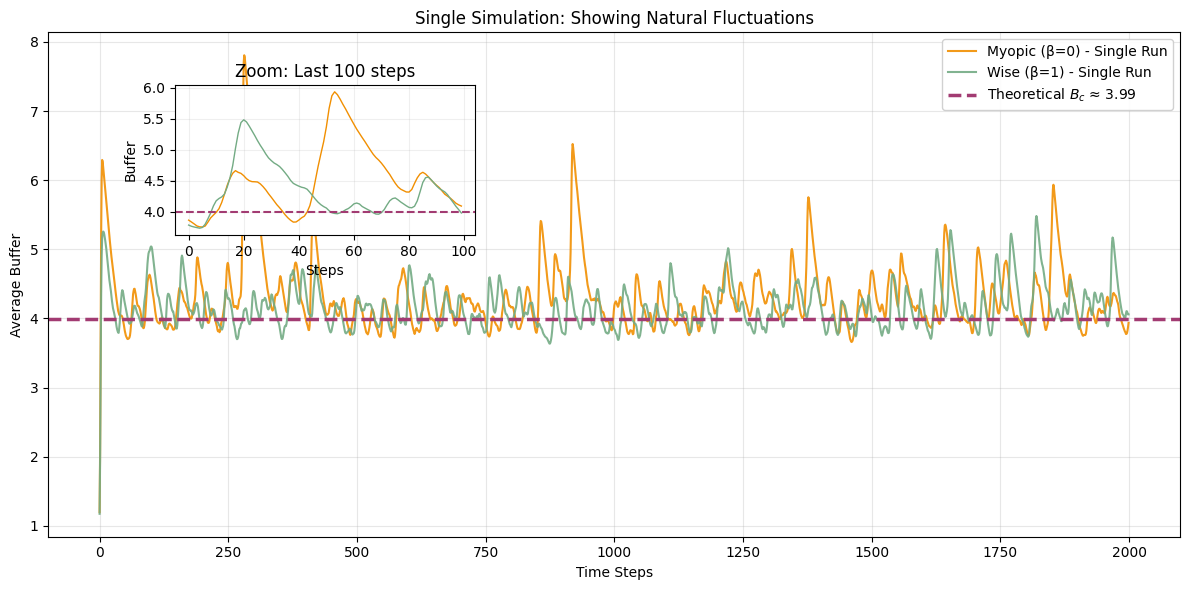

In [126]:
plot_representative_simulation()

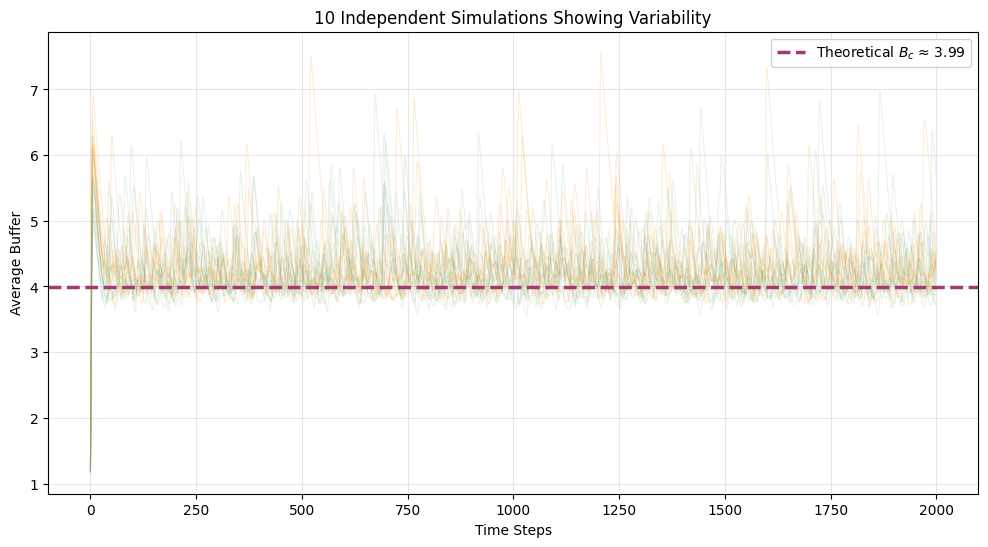

In [128]:
plot_multiple_runs_transparent()